In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential  # type: ignore
from tensorflow.keras.layers import SimpleRNN, Dense # type: ignore

In [2]:
df_gld = pd.read_csv(r"D:\study\tieu_luan_chuyen_nganh\demo\timeseries_hybrid\data\goldprice\gld_price_data.csv")
print(df_gld.head())

       Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099


In [3]:
df_gld['Date'] = pd.to_datetime(df_gld['Date'])

In [4]:
data = df_gld[['GLD']].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
print(scaled_data)

[[0.12967974]
 [0.13587574]
 [0.13203593]
 ...
 [0.48154291]
 [0.47552142]
 [0.45853741]]


In [5]:
split_ratio = 0.8
split_idx = int(len(scaled_data) * split_ratio)
data_train, data_test = scaled_data[:split_idx], scaled_data[split_idx:]

In [6]:
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

In [7]:
time_step = 5
X_train, y_train = create_dataset(data_train, time_step)
X_test, y_test = create_dataset(data_test, time_step)
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_train : (1826, 5, 1) y_train : (1826, 1)


In [9]:
model = Sequential()
model.add(SimpleRNN(units=32, return_sequences=True, input_shape=(time_step, 1)))
model.add(SimpleRNN(units=32, return_sequences=False))
model.add(Dense(16))
model.add(Dense(1))

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')
batch_size = 64
epochs = 30
model_history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0109
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011    
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.2371e-04 
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3248e-04 
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0070e-04
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.0207e-04 
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2816e-04
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3027e-04
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4375e-04
Epoch 10/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5774e-04 
Epoch 11/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6548e-04
Epoch 12/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4862e-04
Epoch 13/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6370e-04
Epoch 14/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7631e-04
Epoch 15/30
29/29 ━━━━━━━━━━━

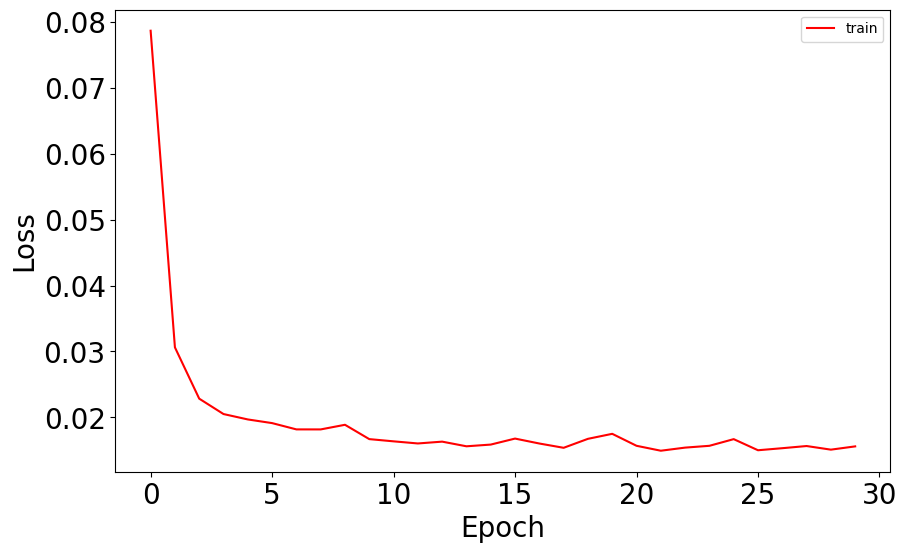

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['loss']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [12]:
model.fit(X_train, y_train, batch_size = 64, epochs = 30)

Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1192e-04
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8976e-04 
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2779e-04
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5997e-04 
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2244e-04 
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0869e-04 
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4571e-04
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2879e-04
Epoch 9/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0693e-04
Epoch 10/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8285e-04
Epoch 11/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2186e-04
Epoch 12/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8439e-04
Epoch 13/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2425e-04
Epoch 14/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3791e-04 
Epoch 15/30
29/29 ━━━━━━

In [13]:
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
predicted_prices = np.reshape(predicted_prices, -1)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [14]:
acctually_prices = data[split_idx+time_step+1:]
acctually_prices = np.reshape(acctually_prices, -1)

In [15]:
# Tính Mean Squared Error
mse = mean_squared_error(acctually_prices, predicted_prices)
print(f"MSE: {mse}")

# Tính MAE
mae = mean_absolute_error(acctually_prices, predicted_prices)
print(f"MAE: {mae}")

#Tính MAPE
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
mape = calculate_mape(acctually_prices, predicted_prices)
print(f"MAPE: {mape}")

MSE: 1.9077426480230832
MAE: 1.05520756813684
MAPE: 0.8696125555902344


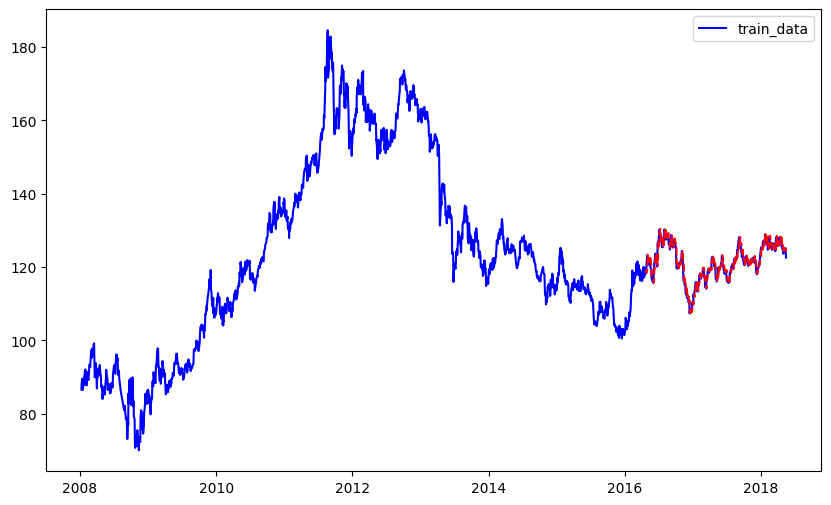

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(df_gld["Date"][time_step:] , data[time_step:],label = "train_data", color = "b")
plt.plot(df_gld["Date"][time_step+split_idx+1:], predicted_prices, color = "red", linestyle = '--')
plt.legend()
plt.show()